1) Przypomnienie zwykłego clusteringu
* k-means
* PAM?

2) Co to jest ensamble clustering
* Generation step
* Consensus step
* Cechy dobrego modelu

3) Przykładowe modele

4) Case study

In [1]:
from sklearn.cluster import KMeans, MiniBatchKMeans, SpectralClustering
from sklearn.metrics import confusion_matrix, accuracy_score, adjusted_rand_score, rand_score
from scipy.optimize import linear_sum_assignment
from sklearn.datasets import make_moons, make_blobs
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse.csgraph import connected_components
from scipy.spatial.distance import cdist
from sklearn.utils import resample


import warnings
warnings.filterwarnings('ignore')

# Dataset creation

In [2]:
def plot_points(dataset, labels=None):
    if labels is None:
        labels = 'cornflowerblue'
    plt.figure(figsize=(8, 8))
    plt.grid(alpha=0.4)
    plt.scatter(dataset[:, 0], dataset[:, 1], c=labels, cmap='tab20')
    # plt.xticks([])
    # plt.yticks([])
    
    plt.show()

(500, 2)


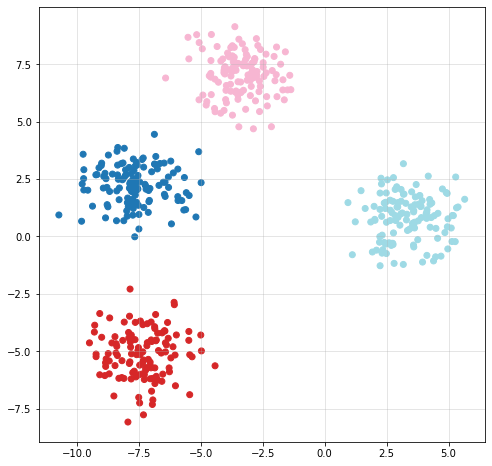

In [3]:
dataset_easy, labels_easy = make_blobs(n_samples=500, n_features=2, centers=4, random_state=43)
print(dataset_easy.shape)
plot_points(dataset_easy, labels_easy)

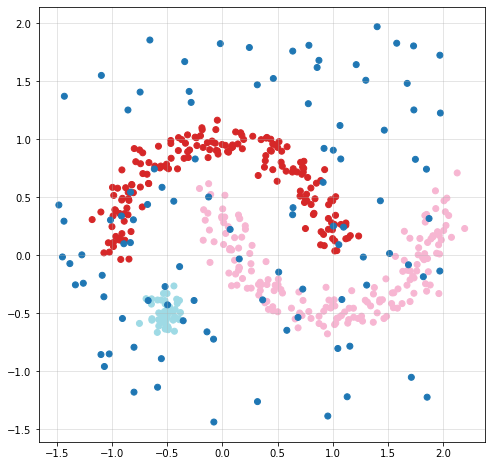

In [4]:
np.random.seed(214)

X_moons, y1 = make_moons(n_samples=350, noise=0.1, random_state=214)
X_blobs, y2 = make_blobs(n_samples=50, centers=[[-0.5,-0.5]], cluster_std=[0.1], random_state=214)
y2 += 2
X_noise = np.random.uniform(low=-1.5, high=2.0, size=(100,2))

dataset_hard = np.vstack([X_moons, X_blobs, X_noise])
labels_hard = np.concatenate([y1, y2, -np.ones(100)])
plot_points(dataset_hard, labels_hard)

(500, 2)


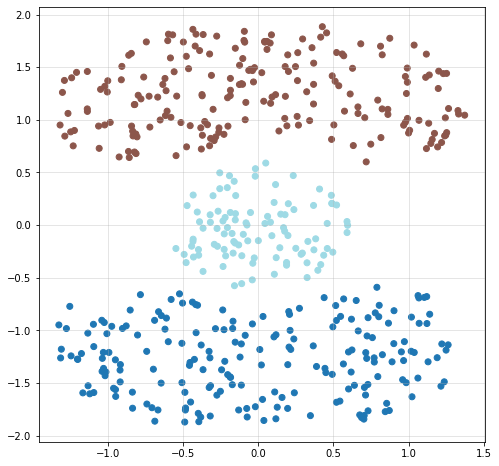

In [5]:
dataset_cassini = np.loadtxt('Data/cassini.csv', delimiter=';')
labels_cassini = np.loadtxt('Data/cassini_labels.csv')
print(dataset_cassini.shape)
plot_points(dataset_cassini, labels_cassini)

In [6]:
def plot_three_datasets(labels1, labels2, labels3, dataset1=dataset_easy, dataset2=dataset_hard, dataset3=dataset_cassini, true_labels1=labels_easy, true_labels2=labels_hard, true_labels3=labels_cassini):
    plt.figure(figsize=(18, 6))
    
    plt.subplot(1, 3, 1)
    plt.grid(alpha=0.4)
    plt.scatter(dataset1[:, 0], dataset1[:, 1], c=labels1, cmap='tab20')
    plt.title(f"Easy Dataset\nRand Idex: {np.round(rand_score(true_labels1, labels1), 2)}\nAdjusted Rand Index: {np.round(adjusted_rand_score(true_labels1, labels1), 2)}")
    
    plt.subplot(1, 3, 2)
    plt.grid(alpha=0.4)
    plt.scatter(dataset2[:, 0], dataset2[:, 1], c=labels2, cmap='tab20')
    plt.title(f"Hard Dataset\nRand Idex: {np.round(rand_score(true_labels2, labels2), 2)}\nAdjusted Rand Index: {np.round(adjusted_rand_score(true_labels2, labels2), 2)}")
    
    plt.subplot(1, 3, 3)
    plt.grid(alpha=0.4)
    plt.scatter(dataset3[:, 0], dataset3[:, 1], c=labels3, cmap='tab20')
    plt.title(f"Cassini Dataset\nRand Idex: {np.round(rand_score(true_labels3, labels3), 2)}\nAdjusted Rand Index: {np.round(adjusted_rand_score(true_labels3, labels3), 2)}")
    
    plt.show()

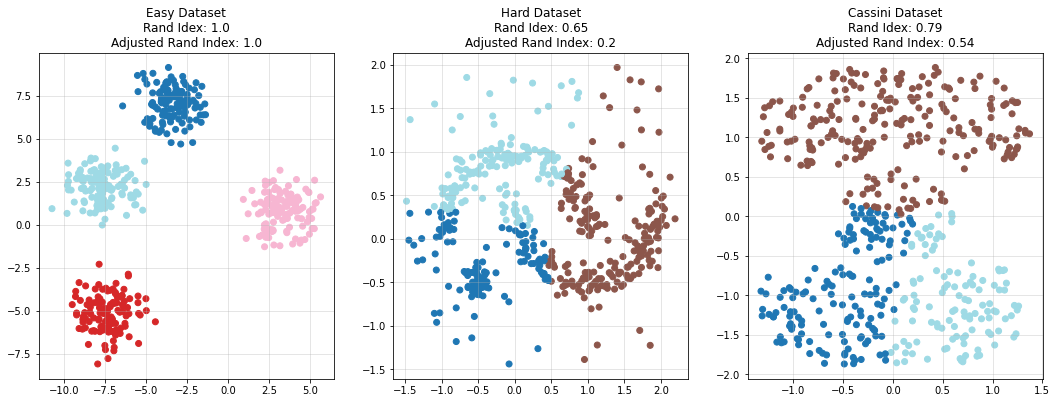

In [7]:
D1 = MiniBatchKMeans(n_clusters=4).fit(dataset_easy).labels_
D2 = MiniBatchKMeans(n_clusters=3).fit(dataset_hard).labels_
D3 = MiniBatchKMeans(n_clusters=3).fit(dataset_cassini).labels_

plot_three_datasets(D1, D2, D3)

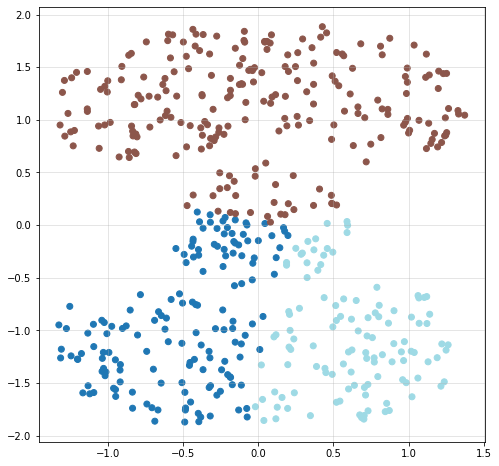

In [8]:
plot_points(dataset_cassini, D3)

In [9]:
class ClusterSimilarityMatrix():
    def __init__(self) -> None:
        self._is_fitted = False

    def fit(self, y_clusters):
        if not self._is_fitted:
            self._is_fitted = True
            self.similarity = self.to_binary_matrix(y_clusters)
            return self

        self.similarity += self.to_binary_matrix(y_clusters)

    def to_binary_matrix(self, y_clusters):
        y_reshaped = np.expand_dims(y_clusters, axis=-1)
        return (cdist(y_reshaped, y_reshaped, 'cityblock')==0).astype(int)

# First method

In [10]:
#https://medium.com/@nielsencastelodamascenodantas/clustering-ensamble-f810fd81deaf
class EnsembleSpectralClustering():
    def __init__(self, clusters_number, base_estimator, base_estimator_num_clusters, estimators_num=100, parameters={}):
        self.clusters_number = clusters_number
        self.base_estimator_num_clusters = base_estimator_num_clusters
        self.estimators_num= estimators_num
        self.clustering_models = self.estimators_num*[base_estimator(n_clusters=self.base_estimator_num_clusters, n_init=1, init = 'random', **parameters)]
        
    def fit(self, X):
        clt_sim_matrix = ClusterSimilarityMatrix()
        for model in self.clustering_models:
            clt_sim_matrix.fit(model.fit(X).labels_)
            
        sim_matrix = clt_sim_matrix.similarity
        norm_sim_matrix = sim_matrix/sim_matrix.diagonal()
        
        spec_clt = SpectralClustering(n_clusters=self.clusters_number, affinity='precomputed')
        return spec_clt.fit_predict(norm_sim_matrix)

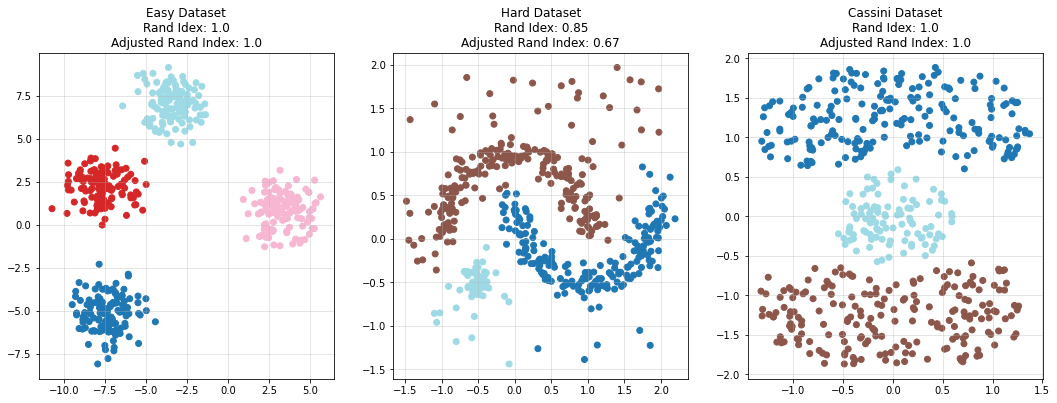

In [11]:
modelD1 = EnsembleSpectralClustering(clusters_number=4,
                                     base_estimator=MiniBatchKMeans,
                                     base_estimator_num_clusters = 20)
modelD2 = EnsembleSpectralClustering(clusters_number=3,
                                     base_estimator=MiniBatchKMeans,
                                     base_estimator_num_clusters = 20)
modelD3 = EnsembleSpectralClustering(clusters_number=3,
                                     base_estimator=MiniBatchKMeans,
                                     base_estimator_num_clusters = 20)

y1 = modelD1.fit(dataset_easy)
y2 = modelD2.fit(dataset_hard)
y3 = modelD3.fit(dataset_cassini)

plot_three_datasets(y1, y2, y3)

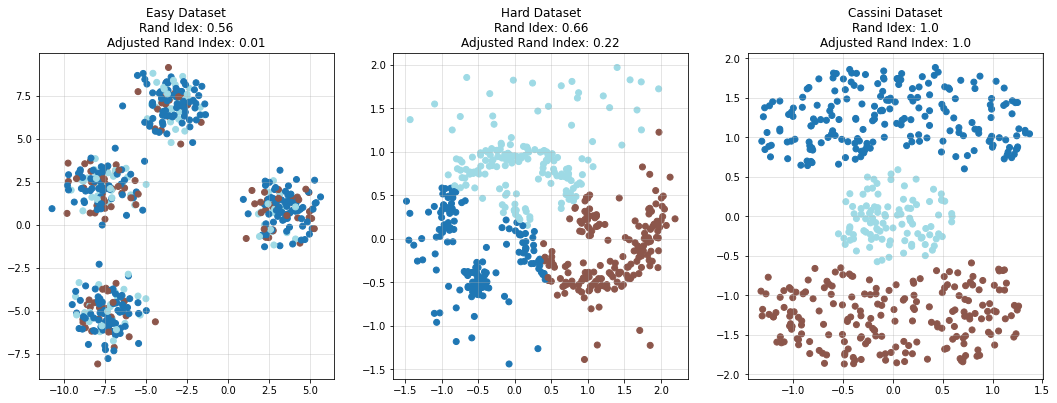

In [12]:
y1 = SpectralClustering(n_clusters=4).fit_predict(dataset_easy)
y2 = SpectralClustering(n_clusters=3).fit_predict(dataset_hard)
y1 = SpectralClustering(n_clusters=3).fit_predict(dataset_cassini)
plot_three_datasets(y1, y2, y3)


# Second method

In [13]:
# https://towardsdatascience.com/how-to-ensemble-clustering-algorithms-bf78d7602265
class GraphConnected():
    def __init__(self, estimator, clusters_number, estimators_num, min_probability, estimator_parameters):
        self.n_clusters = clusters_number
        self.estimator_parameters = estimator_parameters
        self.estimators_num = estimators_num
        self.min_probability = min_probability
        self.clustering_models = self.estimators_num*[estimator(n_clusters = self.n_clusters, **self.estimator_parameters)]
        
    def fit(self, X):
        clt_sim_matrix = ClusterSimilarityMatrix()
        for model in self.clustering_models:
            clt_sim_matrix.fit(model.fit(X).labels_)
            
        sim_matrix = clt_sim_matrix.similarity
        norm_sim_matrix = sim_matrix/sim_matrix.diagonal()
        
        graph = (norm_sim_matrix>self.min_probability).astype(int)
        
        n_clusters, y_ensemble = connected_components(graph, directed=False, return_labels=True)
        
        return y_ensemble

In [39]:
parameters={'n_init': 1}
modelD1 = GraphConnected(estimator=MiniBatchKMeans,
                       clusters_number=8,
                       estimators_num=16,
                       min_probability=0.6,
                       estimator_parameters=parameters)
modelD2 = GraphConnected(estimator=MiniBatchKMeans,
                       clusters_number=8,
                       estimators_num=16,
                       min_probability=0.6,
                       estimator_parameters=parameters)
modelD3 = GraphConnected(estimator=MiniBatchKMeans,
                       clusters_number=8,
                       estimators_num=16,
                       min_probability=0.6,
                       estimator_parameters=parameters)

In [40]:
y1 = modelD1.fit(dataset_easy)
y2 = modelD2.fit(dataset_hard)
y3 = modelD3.fit(dataset_cassini)

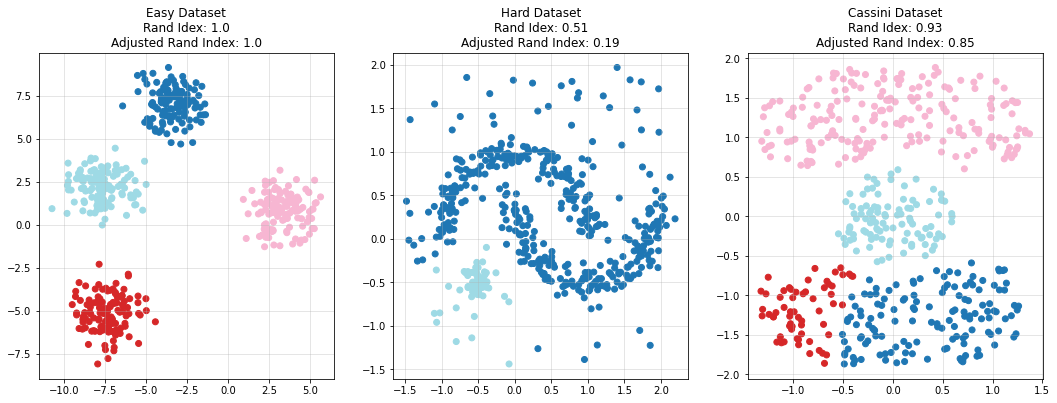

In [41]:
plot_three_datasets(y1, y2, y3)

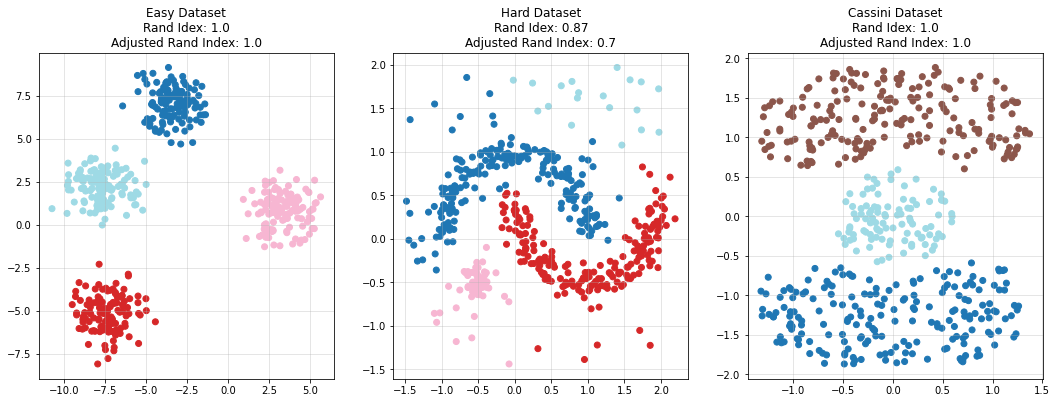

In [42]:
modelD1 = GraphConnected(estimator=MiniBatchKMeans,
                       clusters_number=16,
                       estimators_num=32,
                       min_probability=0.5,
                       estimator_parameters=parameters)
modelD2 = GraphConnected(estimator=MiniBatchKMeans,
                       clusters_number=16,
                       estimators_num=32,
                       min_probability=0.6,
                       estimator_parameters=parameters)
modelD3 = GraphConnected(estimator=MiniBatchKMeans,
                       clusters_number=8,
                       estimators_num=32,
                       min_probability=0.6,
                       estimator_parameters=parameters)

y1 = modelD1.fit(dataset_easy)
y2 = modelD2.fit(dataset_hard)
y3 = modelD3.fit(dataset_cassini)

plot_three_datasets(y1, y2, y3)

# Third method

In [31]:
class BagClust:
    def __init__(self, n_clusters, n_bootstraps=20, clustering_procedure=None):
        self.n_clusters = n_clusters
        self.n_bootstraps = n_bootstraps
        if clustering_procedure is None:
            self.clustering_procedure = lambda X, K: MiniBatchKMeans(n_clusters=K).fit_predict(X)
        else:
            self.clustering_procedure = clustering_procedure

    @staticmethod
    def maximize_overlap(labels_b, indices_b, original_labels, n_samples):
        intersect = np.intersect1d(np.arange(0, n_samples), indices_b)
        relabel = -np.ones(n_samples, dtype=int)
        relabel[indices_b] = labels_b
        common_labels_1, common_labels_2 = original_labels[intersect], relabel[intersect]
        cm = confusion_matrix(common_labels_1, common_labels_2)
        
        cost_matrix = cm.max() - cm
        row_ind, col_ind = linear_sum_assignment(cost_matrix)
        
        new_labels = np.copy(labels_b)
        label_mapping = {old: new for old, new in zip(col_ind, row_ind)}
        for i in range(len(labels_b)):
            new_labels[i] = label_mapping.get(labels_b[i], labels_b[i])
            
        return new_labels

    def fit(self, X):
        n_samples = X.shape[0]
        cluster_votes = np.zeros((n_samples, self.n_clusters))

        original_labels = self.clustering_procedure(X, self.n_clusters)

        for b in range(self.n_bootstraps):
            X_b, indices_b = resample(X, np.arange(n_samples))
            labels_b = self.clustering_procedure(X_b, self.n_clusters)
            
            labels_b = self.maximize_overlap(labels_b, indices_b, original_labels, n_samples)
           
            for i in range(n_samples):
                if i in indices_b:
                    cluster_votes[i, labels_b[np.where(indices_b == i)[0][0]]] += 1

        self.labels_ = np.argmax(cluster_votes, axis=1)
        return self

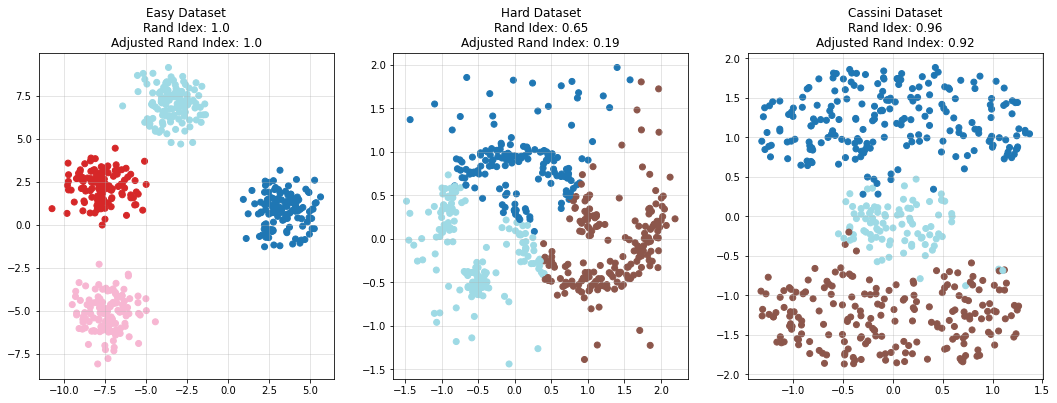

In [32]:
modelD1 = BagClust(n_clusters=4, n_bootstraps=50)
modelD2 = BagClust(n_clusters=3, n_bootstraps=50)
modelD3 = BagClust(n_clusters=3, n_bootstraps=50)

y1 = modelD1.fit(dataset_easy).labels_
y2 = modelD2.fit(dataset_hard).labels_
y3 = modelD3.fit(dataset_cassini).labels_

plot_three_datasets(y1, y2, y3)